In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k

###################################
# TensorFlow wizardry
config = tf.ConfigProto()

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1 # 0.5 for Half

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))


Using TensorFlow backend.


In [3]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model

import tensorflow as tf
import keras
import seaborn as sn
import pandas as pd
import numpy as np
import linecache
import sys
import h5py
import itertools
import matplotlib.pyplot as plt
import os
import pickle
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

In [4]:
tf.__version__

'1.9.0'

In [5]:
train_path = '/data/danish/Data/Malimg-Color-25-Families/Malimg-Colorimage-train/'
test_path  = '/data/danish/Data/Malimg-Color-25-Families/Malimg-Colorimage-test/'

In [6]:
datagen_train = ImageDataGenerator(
      rescale=1./255#,
      #rotation_range=0.1,#180,
      #width_shift_range=0.1,
      #height_shift_range=0.1,
      #shear_range=0.1,
      #zoom_range=0.1,#[0.9, 1.5],
      #horizontal_flip=True,
      #vertical_flip=True,
      #fill_mode='nearest'
                )

datagen_test = ImageDataGenerator(rescale=1./255)


In [7]:
if False:
    save_to_dir='augmented_images/'
else:
    save_to_dir = None

In [8]:
input_shape=(224,224)
batch_size=32
save_fn='Deep_Learning_Model_for_Malimg_size_GrayScale='+str(input_shape[:])
save_fn

'Deep_Learning_Model_for_Malimg_size_GrayScale=(224, 224)'

In [9]:
generator_train = datagen_train.flow_from_directory(directory=train_path,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=42)


steps_train = generator_train.n/ batch_size
print("Steps for Training",steps_train)

cls_train = generator_train.classes
print(cls_train)
cls_names_train = list(generator_train.class_indices.keys())
print(cls_names_train)
num_cls_train = len(cls_names_train)
print("Number of Classes in Training Data",num_cls_train)

Found 6527 images belonging to 25 classes.
Steps for Training 203.96875
[ 0  0  0 ..., 24 24 24]
['AdialerC', 'AgentFYI', 'AllapleA', 'AllapleL', 'Aluerongen!J', 'AutorunK', 'C2LOPP', 'C2LOPgen!g', 'DialplatformB', 'DontovoA', 'Fakerean', 'Instantaccess', 'LolydaAA1', 'LolydaAA2', 'LolydaAA3', 'LolydaAT', 'Malexgen!J', 'ObfuscatorAD', 'Rbot!gen', 'SkintrimN', 'Swizzorgen!E', 'Swizzorgen!I', 'VBAT', 'WintrimBX', 'YunerA']
Number of Classes in Training Data 25


In [10]:
from sklearn.utils.class_weight import compute_class_weight
class_weight_train = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

In [12]:
#cls_names_train
class_labels = ['AdialerC','AgentFYI','AllapleA','AllapleL','Aluerongen!J','AutorunK','C2LOPP','C2LOPgen!g','DialplatformB','DontovoA',
 'Fakerean','Instantaccess','LolydaAA1','LolydaAA2','LolydaAA3','LolydaAT','Malexgen!J','ObfuscatorAD','Rbot!gen','SkintrimN',
 'Swizzorgen!E','Swizzorgen!I','VBAT','WintrimBX','YunerA']
list_fams = class_labels

In [13]:
class_weight_train

array([ 3.07152941,  3.22320988,  0.12649225,  0.23457323,  1.89188406,
        3.52810811,  2.55960784,  1.86485714,  2.12260163,  2.31044248,
        0.98150376,  0.86737542,  1.75221477,  2.0396875 ,  3.03581395,
        2.35207207,  2.74821053,  2.63717172,  2.37345455,  4.66214286,
        2.93348315,  2.83782609,  0.91607018,  3.89671642,  0.46621429])

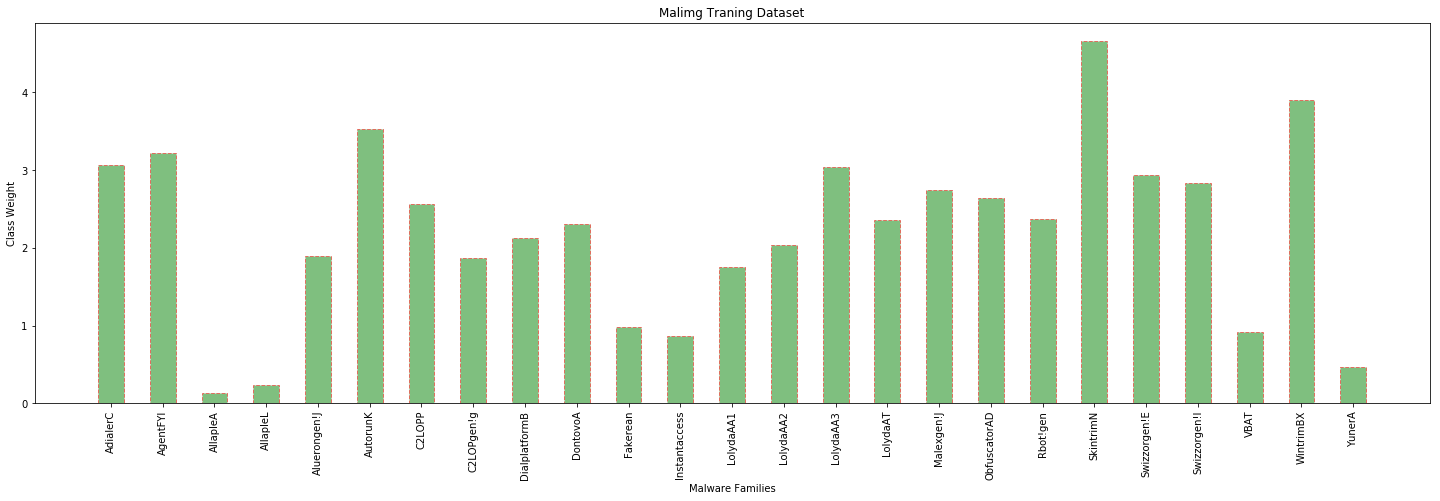

In [14]:
objects = class_labels#class_dictionary_train#cls_names_train#('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = class_weight_train#[10,8,6,4,2,1]
plt.figure(figsize = (25,7))
plt.bar(y_pos, performance, align='center', alpha=0.5, color='g', linestyle='--', width=0.5, edgecolor='r', )
plt.xticks(y_pos, objects, rotation='vertical')
plt.xlabel('Malware Families')
plt.ylabel('Class Weight')
plt.title('Malimg Traning Dataset')
 
plt.show()

In [15]:
generator_test = datagen_test.flow_from_directory(directory=test_path,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  seed=42)

steps_test = generator_test.n / batch_size
steps_test
print("Steps for Test",steps_test)

cls_test = generator_test.classes
print(cls_test)
cls_names_test = list(generator_test.class_indices.keys())
print(cls_names_test)
num_cls_test = len(cls_names_test)
print("Number of Classes in Test Data",num_cls_test)

Found 2812 images belonging to 25 classes.
Steps for Test 87.875
[ 0  0  0 ..., 24 24 24]
['AdialerC', 'AgentFYI', 'AllapleA', 'AllapleL', 'Aluerongen!J', 'AutorunK', 'C2LOPP', 'C2LOPgen!g', 'DialplatformB', 'DontovoA', 'Fakerean', 'Instantaccess', 'LolydaAA1', 'LolydaAA2', 'LolydaAA3', 'LolydaAT', 'Malexgen!J', 'ObfuscatorAD', 'Rbot!gen', 'SkintrimN', 'Swizzorgen!E', 'Swizzorgen!I', 'VBAT', 'WintrimBX', 'YunerA']
Number of Classes in Test Data 25


In [16]:
class_dictionary_test = generator_test.class_indices
class_dictionary_test

{'AdialerC': 0,
 'AgentFYI': 1,
 'AllapleA': 2,
 'AllapleL': 3,
 'Aluerongen!J': 4,
 'AutorunK': 5,
 'C2LOPP': 6,
 'C2LOPgen!g': 7,
 'DialplatformB': 8,
 'DontovoA': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'LolydaAA1': 12,
 'LolydaAA2': 13,
 'LolydaAA3': 14,
 'LolydaAT': 15,
 'Malexgen!J': 16,
 'ObfuscatorAD': 17,
 'Rbot!gen': 18,
 'SkintrimN': 19,
 'Swizzorgen!E': 20,
 'Swizzorgen!I': 21,
 'VBAT': 22,
 'WintrimBX': 23,
 'YunerA': 24}

In [17]:
from sklearn.utils.class_weight import compute_class_weight
class_weight_test = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_test),
                                    y=cls_test)

In [18]:
class_weight_test

array([ 3.04      ,  3.21371429,  0.12709605,  0.23531381,  1.87466667,
        3.515     ,  2.55636364,  1.87466667,  2.08296296,  2.2955102 ,
        0.97808696,  0.86523077,  1.7575    ,  2.00857143,  3.04      ,
        2.34333333,  2.74341463,  2.61581395,  2.34333333,  4.68666667,
        2.88410256,  2.812     ,  0.91447154,  3.74933333,  0.46866667])

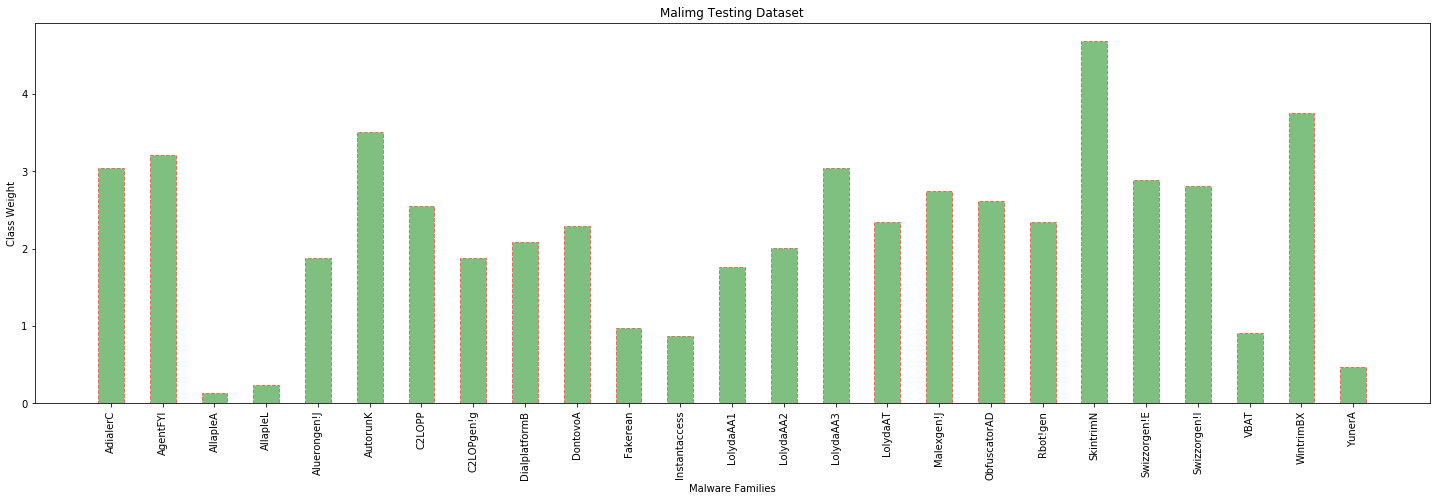

In [19]:
objects = class_labels#class_dictionary_train#cls_names_train#('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = class_weight_test#[10,8,6,4,2,1]
plt.figure(figsize = (25,7))
plt.bar(y_pos, performance, align='center', alpha=0.5, color='g', linestyle='--', width=0.5, edgecolor='r', )
plt.xticks(y_pos, objects, rotation='vertical')
plt.xlabel('Malware Families')
plt.ylabel('Class Weight')
plt.title('Malimg Testing Dataset')
 
plt.show()

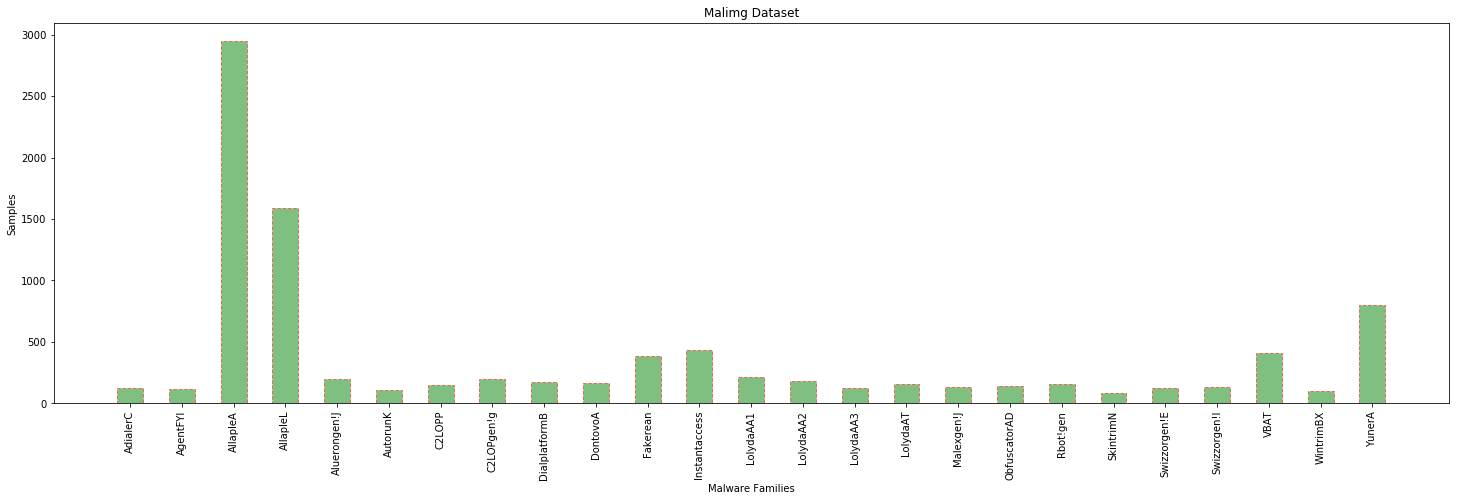

In [20]:
objects = class_labels#class_dictionary_train#cls_names_train#('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = [122,116,2949,1591,198,106,146,200,177,162,381,431,213,184,123,159,136,142,158,80,128,132,408,97,800]
plt.figure(figsize = (25,7))
plt.bar(y_pos, performance, align='center', alpha=0.5, color='g', linestyle='--', width=0.5, edgecolor='r', )
plt.xticks(y_pos, objects, rotation='vertical')
plt.xlabel('Malware Families')
plt.ylabel('Samples')
plt.title('Malimg Dataset')
 
plt.show()

In [21]:
model_ = keras.applications.vgg16.VGG16()#include_top=True, weights=None, input_tensor=None, input_shape=(224,224,1), classes=num_cls_train)

KeyboardInterrupt: 

In [21]:
transfer_layer = model_.get_layer('fc2')

In [22]:
transfer_layer.output

<tf.Tensor 'fc2/Relu:0' shape=(?, 4096) dtype=float32>

In [23]:
conv_model = Model(inputs=model_.input,
                   outputs=transfer_layer.output)

In [24]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [25]:
# Start a new Keras Sequential model.
model = Sequential()

# Add the convolutional part of the VGG16 model from above.
model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
#model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
#model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
#model.add(Dropout(0.5))

# Add the final layer for the actual classification.
model.add(Dense(num_cls_train, activation='softmax'))

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 4096)              134260544 
_________________________________________________________________
dense_1 (Dense)              (None, 25)                102425    
Total params: 134,362,969
Trainable params: 134,362,969
Non-trainable params: 0
_________________________________________________________________


In [27]:

#model.load_weights('Deep_Learning_Model_for_Malimg_size=(192, 192)_Weights.hdf5')
model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])


In [28]:
epochs =10
steps_per_epoch=steps_train

In [29]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import RemoteMonitor



history = model.fit_generator(generator=generator_train,
                                epochs=epochs,
                                steps_per_epoch=steps_per_epoch,
                                validation_data=generator_test,
                                validation_steps=steps_test
                                )




Epoch 1/10
204/203 [==============================] - 99s 485ms/step - loss: 0.5164 - acc: 0.8664 - val_loss: 0.1934 - val_acc: 0.9353
Epoch 2/10
204/203 [==============================] - 83s 405ms/step - loss: 0.1545 - acc: 0.9588 - val_loss: 0.1932 - val_acc: 0.9513
Epoch 3/10
204/203 [==============================] - 82s 401ms/step - loss: 0.0964 - acc: 0.9677 - val_loss: 0.0833 - val_acc: 0.9719
Epoch 4/10
204/203 [==============================] - 82s 402ms/step - loss: 0.3724 - acc: 0.9191 - val_loss: 0.2628 - val_acc: 0.9214
Epoch 5/10
204/203 [==============================] - 82s 401ms/step - loss: 0.1315 - acc: 0.9591 - val_loss: 0.1185 - val_acc: 0.9602
Epoch 6/10
204/203 [==============================] - 83s 405ms/step - loss: 0.0778 - acc: 0.9747 - val_loss: 0.1008 - val_acc: 0.9619
Epoch 7/10
204/203 [==============================] - 83s 405ms/step - loss: 0.0671 - acc: 0.9763 - val_loss: 0.1083 - val_acc: 0.9708
Epoch 8/10
204/203 [==============================] - 8

In [22]:
from keras.models import load_model
model = load_model('Original-VGG16-Color.h5')

In [76]:
sample = generator_test[85][0][0]
print(np.array(sample).shape)
sample = np.expand_dims(sample, axis=0)
print(sample.shape)

#sample = np.array(sample)

(224, 224, 3)
(1, 224, 224, 3)


In [77]:
import time
tic = time.time();

cls_pred = model.predict(sample, verbose=1)#, steps_test, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)

toc = time.time();
print ("Elasped Time (s) = ", toc-tic);

1/1 [==============================] - 1s 897ms/step
Elasped Time (s) =  0.8989191055297852


In [23]:

# read Traning History back from the file
pkl_file = open("Original-VGG16-Color-History.pkl", 'rb')
history = pickle.load(pkl_file)
pkl_file.close()

In [24]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history) 

csv_file = 'Original-VGG16-Color-History.csv'
with open(csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [25]:
#scores = model.evaluate(X[test], Y[test], verbose=0)
#model.load_weights('Model_VGG16_Malimg_RGB_Trained_(229, 229)_Epochs=100_Model_Traning_Testing_Weights.hdf5')
scores = model.evaluate_generator(generator_test, verbose=1)# steps_test, max_queue_size=10, workers=1, use_multiprocessing=False,verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

88/88 [==============================] - 21s 236ms/step
acc: 97.12%


In [23]:
cls_pred = model.predict_generator(generator_test, verbose=1)#, steps_test, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)

88/88 [==============================] - 24s 270ms/step


In [24]:
cls_pred = np.argmax(cls_pred, axis=1)

In [ ]:
y_test = cls_test = generator_test.classes

from pycm import ConfusionMatrix
CM_IMCFN = ConfusionMatrix(y_test,cls_pred)
file = open('CM-Original-VGG16-Color.pkl', 'wb')
pickle.dump(CM_IMCFN, file)
file.close()

In [ ]:
file = open('CM-Original-VGG16-Color.pkl', 'rb')
CM_IMCFN = pickle.load(file)
file.close()

In [ ]:
CM_IMCFN.stat(summary=True)

In [ ]:
CM_IMCFN.save_csv("CM-Original-VGG16-Color",address=True)

In [ ]:
%%time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
cls_true = cls_test = generator_test.classes
accuracy = accuracy_score(cls_true, cls_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(cls_true, cls_pred, average=None)

print("All Classes")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

In [ ]:
%%time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
cls_true = cls_test = generator_test.classes
accuracy = accuracy_score(cls_true, cls_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(cls_true, cls_pred, average='micro')

print("Micro")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

In [ ]:
%%time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
cls_true = cls_test = generator_test.classes
accuracy = accuracy_score(cls_true, cls_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(cls_true, cls_pred, average='macro')

print("Macro")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

In [ ]:
%%time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
cls_true = cls_test = generator_test.classes
accuracy = accuracy_score(cls_true, cls_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(cls_true, cls_pred, average='weighted')

print("weighted")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

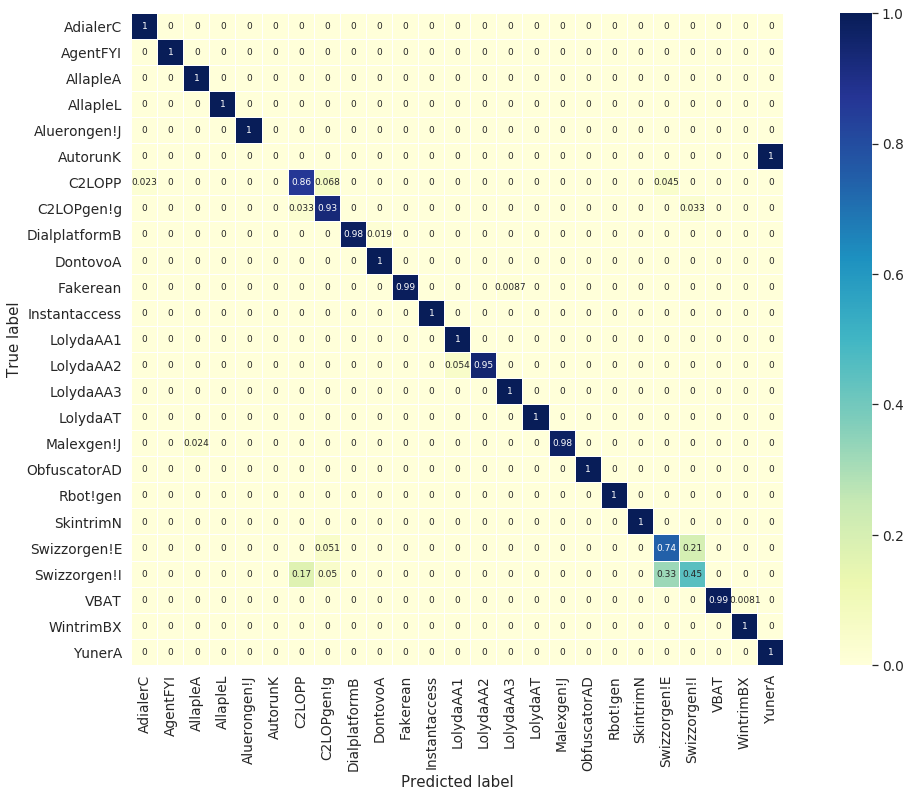

In [26]:
def plot_confusion_matrix():
    

    cm = confusion_matrix(cls_test, cls_pred)
    
    cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    
    figure = plt.gcf()
    figure.set_size_inches(20, 12)
    sn.set(font_scale=1.25)
    hm = sn.heatmap(cm, cmap= "YlGnBu" ,cbar=True, annot=True, square=True,
                 annot_kws={'size': 9}, linewidth = 0.01,
                 yticklabels=list_fams, xticklabels=list_fams)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.savefig('VGG16-YlGnBu.png', bbox_inches='tight')
    plt.show()
    
plot_confusion_matrix()